In [1]:
# enable autocomplete
%config Completer.use_jedi = False

In [91]:
import pandas as pd
import numpy as np



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

# classification models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import pickle

# Train different classification models to predict user type

## Load data

In [3]:
df = pd.read_csv('data/citibike2018_features.csv')

In [4]:
df.shape

(17370335, 12)

In [5]:
df.tail()

,tripduration,starthour,startday,startmonth,startweekday,isweekend,start station id,end station id,geodesic_distance,usertype,birth year,gender
17370330,734,23,31,12,0,False,336.0,379.0,2.167842,Subscriber,1986,1
17370331,2551,23,31,12,0,False,3320.0,2006.0,3.327267,Customer,1969,0
17370332,2376,23,31,12,0,False,427.0,259.0,0.155175,Subscriber,1979,1
17370333,2758,23,31,12,0,False,3320.0,281.0,3.419638,Customer,1969,0
17370334,2459,23,31,12,0,False,128.0,402.0,1.856612,Subscriber,1996,2


## Create train-test-split

In [6]:
X = df.drop(['usertype'], axis=1)
y = df["usertype"].map({'Subscriber':1 , 'Customer': 0})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Create encodings

In [8]:
# divide numerical and categorical columns
num_cols = ['tripduration', 'geodesic_distance', 'birth year']
cat_cols = ['starthour', 'startday', 'startmonth', 'startweekday', 'isweekend', 'start station id', 'end station id', 'gender']

In [9]:
# standard scaler for numerical columns
numeric_transformer = StandardScaler()

# one-hot encoding for categorical columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

## Define candidate models

In [10]:
# define search space of classification models
search_space = [{'classifier': [SVC()]},
                {'classifier': [RandomForestClassifier()]},
                {'classifier': [KNeighborsClassifier()]},
                {'classifier': [XGBClassifier()]}]

## Define cross validation pipeline

In [11]:
pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", SVC())])

## Create a smaller training data subset for faster model selection

In [17]:
X_small, _, y_small, _ = train_test_split(X_train, y_train, test_size=0.99, random_state=42, stratify=y_train)

In [18]:
X_small.shape

(138962, 11)

## Select model type with cross validation

In [71]:
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42), verbose=0, n_jobs=4)
clf = clf.fit(X_small, y_small)

In [72]:
clf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tripduration',
                                                   'geodesic_distance',
                                                   'birth year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['starthour', 'startday',
                                                   'startmonth', 'startweekday',
                                                   'isweekend',
                                                   'start station id',
                                                   'end station id',
                                                   'gender'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtr...
                 

In [73]:
clf.best_score_

0.9502813718858394

In [74]:
clf.cv_results_

{'mean_fit_time': array([1.83772707e+02, 3.63522195e+01, 8.46208334e-02, 1.26776803e+00]),
 'std_fit_time': array([0.06137455, 0.07144892, 0.0002619 , 0.00281298]),
 'mean_score_time': array([4.48435482e+01, 2.10101664e+00, 1.44682635e+02, 8.80674124e-02]),
 'std_score_time': array([5.79112887e-01, 1.29839182e-02, 1.32362115e+00, 1.11472607e-03]),
 'param_classifier': masked_array(data=[SVC(), RandomForestClassifier(),
                    KNeighborsClassifier(),
                    XGBClassifier(base_score=None, booster=None, callbacks=None,
                                  colsample_bylevel=None, colsample_bynode=None,
                                  colsample_bytree=None, early_stopping_rounds=None,
                                  enable_categorical=False, eval_metric=None, gamma=None,
                                  gpu_id=None, grow_policy=None, importance_type=None,
                                  interaction_constraints=None, learning_rate=None, max_bin=None,
           

## Tuning XGBClassifier

In [33]:
# add classifier to param grid
param_grid = {'classifier': [XGBClassifier()]}

In [39]:
param_grid.update({
    "classifier__max_depth": [3, 4, 5, 7],
    "classifier__learning_rate": [0.1, 0.01, 0.05],
    "classifier__gamma": [0, 0.25, 1],
    "classifier__reg_lambda": [0, 1, 10],
    "classifier__scale_pos_weight": [1, 3, 5],
    "classifier__subsample": [0.8],
    "classifier__colsample_bytree": [0.5],
})

In [40]:
tuning_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier())])

In [41]:
xgb_clf = GridSearchCV(tuning_pipe, param_grid, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42), verbose=0, n_jobs=4)
xgb_clf = xgb_clf.fit(X_small, y_small)

In [42]:
xgb_clf.best_score_

0.9507851169631505

## Train XGB on full training data

In [60]:
xgb_best_params = xgb_clf.best_estimator_['classifier'].get_params()

In [61]:
xgb_best_params

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0.25,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 7,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [62]:
xgb_final = XGBClassifier()

In [63]:
xgb_final.set_params(**xgb_best_params)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [65]:
pipe_final = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb_final)])

In [66]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tripduration',
                                                   'geodesic_distance',
                                                   'birth year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['starthour', 'startday',
                                                   'startmonth', 'startweekday',
                                                   'isweekend',
                                                   'start station id',
                                                   'end station id',
                                                   'gender'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtr...
                 

In [67]:
y_pred = pipe_final.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred, target_names=['Customer', 'Subscriber']))

              precision    recall  f1-score   support

    Customer       0.89      0.62      0.73    361270
  Subscriber       0.96      0.99      0.97   3112797

    accuracy                           0.95   3474067
   macro avg       0.92      0.80      0.85   3474067
weighted avg       0.95      0.95      0.95   3474067



/home/sibu/.conda/envs/citibike/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


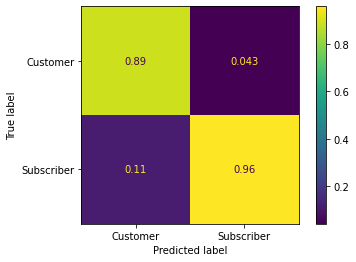

In [90]:
plot_confusion_matrix(pipe_final, X_test, y_test, display_labels=['Customer', 'Subscriber'], normalize='pred')  

In [99]:
# save final pipeline
#pickle.dump(pipe_final, open('tuned_xgb_model.pkl', 'wb'))